<a href="https://colab.research.google.com/github/r00tdotexe/CV-Exercises/blob/main/data_augmentation_medical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [83]:
!pip install -U tensorflow-addons
import tensorflow_addons as tfa


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#**File Management**
#1. Import image data

In [194]:
from google.colab import files
uploaded = files.upload()

Saving roentgen.jpg to roentgen.jpg


#2. Convert into class 'tensorflow.python.framework.ops.EagerTensor'

In [390]:
# load image via tf.io
or_img = tf.io.read_file("roentgen.jpg")
print(type(or_img))

# convert to tensor (specify 3 channels explicitly since png files contains additional alpha channel)
# set the dtypes to align with pytorch for comparison since it will use uint8 by default
tensor = tf.io.decode_image(or_img, channels=3, dtype=tf.dtypes.float32)

# resize tensor to 224 x 224
img = tf.image.resize(tensor, [224, 224])

<class 'tensorflow.python.framework.ops.EagerTensor'>


#3. Create visualization function to compare original and augmented image

In [70]:
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)


#**Geometrical Transformations**
#1. Rotation
This transformation, as its name indicates, consists of rotating the original image according to a desired angle. In medical image analysis, it is common to augment a dataset with random rotations at different angles ranging from 10° to 175° [1] or from -15° to +15° as well as multiples of 45° [2].

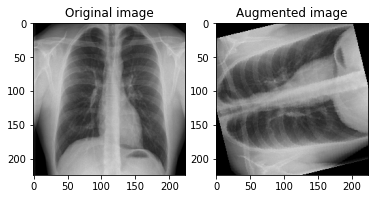

In [116]:
turn_img_2 = tfa.image.rotate(img, tf.constant(tf.random.uniform((1,), 
                                                        minval = 0.1745,
                                                        maxval = 3.054)))
visualize(img,turn_img_2)

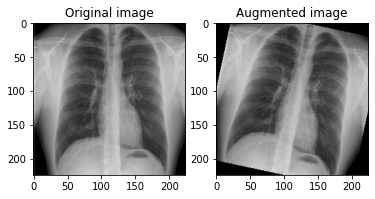

In [113]:
turn_img_3 = tfa.image.rotate(img, tf.constant(tf.random.uniform((1,), 
                                                        minval = -0.2617,
                                                        maxval = 0.2617)))
visualize(img,turn_img_3)

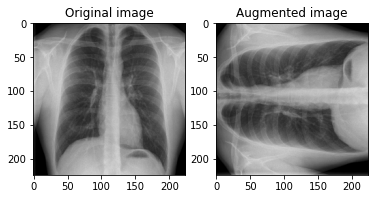

In [132]:
n = np.random.randint(4)
turn_img_3 = tfa.image.rotate(img, n*0.7853)
visualize(img,turn_img_3)

#2. Flips
The image flips are performed along an axis of symmetry. For medical image enhancement, they can be performed vertically as well as horizontally, because images can be acquired in supine or prone position, and contain anatomical variations (e.g. situs inversus). Therefore, an organ, whatever its location in the body, will always be the same organ. Contrary to the case of natural images where, depending on the type of object represented, vertical reflections (e.g. a cat) are of no real interest, because the reflected image is considered unrealistic. [1]

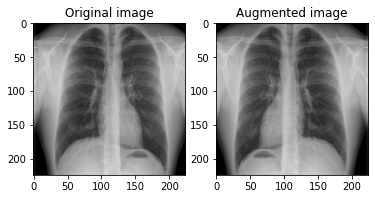

In [133]:
flip_rl_img = tf.image.flip_left_right(img)    
visualize(img, flip_rl_img)

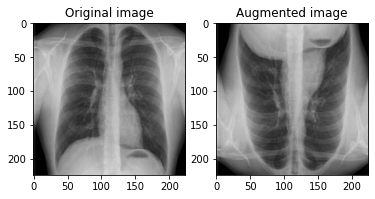

In [134]:
flip_ud_img = tf.image.flip_up_down(img)    
visualize(img, flip_ud_img)

#3. Shift
This transformation can be performed along the x and/or y axis randomly [3][4]. The transformed image keeps the same orientation as the original image and is moved in the applied direction.

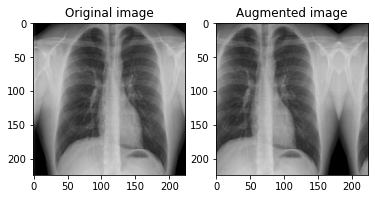

In [180]:
shift_img = tf.keras.preprocessing.image.random_shift(
    img,
    wrg=0.2,
    hrg=0.5,
    row_axis=1, 
    col_axis=1,
    fill_mode='reflect'
)
visualize(img, shift_img)

#4. Crop and zoom
Both methods have the same visual result, some parts of the image are cropped to keep only a part of it.
When cropping, the image dimensions will be reduced (e.g. cropping a 512x512 image to a 250x250 image) and the aspect ratio is not necessarily maintained.
When zooming, the crop retains the same aspect ratio as the original image. The image is resized identically to the original image. To do this, the pixels created to recover the original dimensions have a value interpolated from a function defined before applying the zoom to the original image (e.g. the average brightness of the neighboring pixels). As a result, a loss of quality can be observed. [5][6]
This type of transformation is usually applied randomly to the dataset. [7]

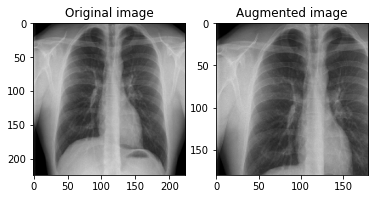

In [260]:
cropped_img = tf.image.crop_to_bounding_box(img, 0, 0, 180, 180)
visualize(img, cropped_img)

#5. Shear
Horizontal shearing (along the x-axis) and/or vertical shearing (along the y-axis) is an affine transformation that consists of shifting in opposite directions the top and bottom of the image (horizontal shearing) or the right and left of the image (vertical shearing). Unlike the previous methods, the image is distorted [8]. Shearings performed on medical images have for example parameter values ranging from 0.1 to 0.35 [1] or with an x/y ratio of up to 15% [9].

0.1 to 0.35 in degrees: 5.73 to 20.05

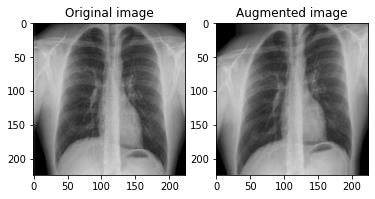

In [326]:
n = np.random.uniform(5.73, 20.05)	
array_inputs = tf.keras.preprocessing.image.img_to_array(img)
sheared = tf.keras.preprocessing.image.random_shear(array_inputs, n,
                                        row_axis=0, col_axis=1,
                                        channel_axis=2)
visualize(img, sheared)

# **Miscellaneous** **Tansformations**


#1. Adding noise
Noise is a random variation in brightness within the image. It degrades the quality of the original image and can be of several types: white Gaussian noise, Poisson noise, impulse noise (salt and pepper). [10]

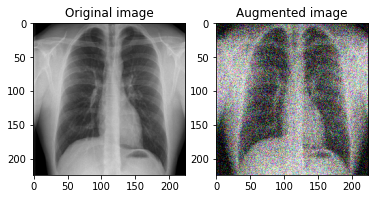

In [344]:
gauss_img = tf.keras.layers.GaussianNoise(
    0.2, seed=None
)(img, training=True)
visualize(img, gauss_img)

#2. Gaussian filter
This convolution filter has a kernel of Gaussian shape. It scans the entire original image to denoise or blur it, by applying a Gaussian function to the pixels of the image. This one realizes a weighted average of the convolved pixels by granting a more important weight to the pixels near the center of the kernel (contrary to an average filter where each pixel present in the kernel has the same weight). [11]

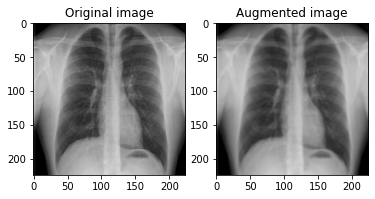

In [362]:
from tensorflow._api.v2 import image
filt_img = tfa.image.gaussian_filter2d(
    img,
    (3, 3),
    3
)
visualize(img, filt_img)

#3. Contrast
The contrast of an image is increased when the darker pixels of this image are darkened and the lighter pixels are lightened: a contrasted image will therefore contain a greater quantity of black and white (see histogram of the example below). You can see the increase in contrast on the histogram of the image, because the gap between the brightest pixels and darkest pixels of the image is greater: the histogram is more spread out, as can be seen when we go from the histogram of the image (b) to the histogram of the image (a). The contrast of an image corresponds to this spread. [12] Thus when the contrast continues to be increased, the number of white and black pixels contained in the image also increases, as can be seen by comparing the histograms of images (a) and (c). The contrast variations performed for data augmentation from medical images can range from 0.8 to 1.2, for example, and are often applied randomly to the dataset. [2]

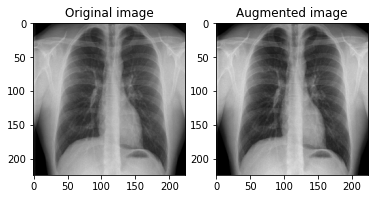

In [370]:
n = np.random.uniform(0.8, 1.2)
contr_img = tf.image.adjust_contrast(
    img, n
)
visualize(img, contr_img)


#3. Brightness
In the HSV (Hue, Saturation, Value) perceptual space, grayscale images have a zero value of saturation and no specific hue. These images are value dependent, i.e. the lower the value of the latter, the darker the image. In order to increase the size of the data set in medical imaging, brightness variations belonging to the interval [-0.1; 0.1] can be applied randomly. [2]

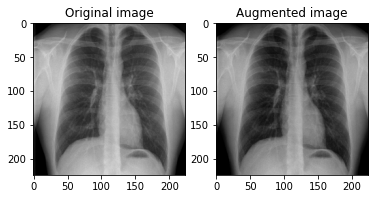

In [376]:
n = np.random.uniform(-0.1, 0.1)
bright_img = tf.image.adjust_brightness(img, n)
visualize(img, bright_img)


#5. Sharpening
This transformation increases the contrast at the edges of the image. Light and dark voxels located in the same area will be lightened and darkened after this transformation. The application is performed with a certain radius around the edge pixel, it corresponds to the number of pixels surrounding this target pixel and the larger the radius, the greater the accentuation of the edges. The same is true for the noise present in the image if it isn’t attenuated beforehand [13]. By focusing on the boundaries between regions within the image and not on the overall contrast, the image appears sharper.

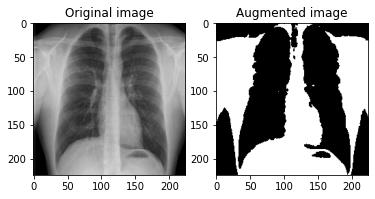

In [389]:
sharp_img = tfa.image.sharpness(
    img,
    0.1
) 
visualize(img, sharp_img)

#**Bibliography**
[1] Hussain, Z., Gimenez, F., Yi, D., & Rubin, D. (2018). Differential data augmentation techniques for medical imaging classification tasks. AMIA ... Annual Symposium proceedings. AMIA Symposium, 2017, 979-984.

[2] Chaitanya, K., Karani, N., & Baumgartner, C. F. (2021). Semi-supervised task-driven data augmentation for medical image segmentation. Medical Image Analysis, 68, 101934. https://doi.org/10.1016/j.media.2020.101934 

[3] Sharma, K., Rupprecht, C., Caroli, A. & al. (2017). Automatic Segmentation of Kidneys using Deep Learning for Total Kidney Volume Quantification in Autosomal Dominant Polycystic Kidney Disease. Scientific Reports, 7(1). https://doi.org/10.1038/s41598-017-01779-0 

[4] Alnazer, I., Bourdon, P., Urruty, T., Falou, O., Khalil, M., Shahin, A., & Fernandez-Maloigne, C. (2021). Recent advances in medical image processing for the evaluation of chronic kidney disease. Medical Image Analysis, 69, 101960. https://doi.org/10.1016/j.media.2021.101960 

[5] Wikipedia contributors. (2020, December 4). Digital zoom. Wikipedia. https://en.wikipedia.org/wiki/Digital_zoom?oldid=992263410 

[6] Wikipedia contributors. (2021, May 15). Cropping (image). Wikipedia. https://en.wikipedia.org/wiki/Cropping_(image) 

[7] Khan, A. R., Khan, S., Harouni, M., Abbasi, R., Iqbal, S., & Mehmood, Z. (2021). Brain tumor segmentation using K-means clustering and deep learning with synthetic data augmentation for classification. Microscopy Research and Technique. Published. https://doi.org/10.1002/jemt.23694 

[8] 4.7. Cisaillement. (s. d.). GIMP. Consulté le 31 mai 2021, à l’adresse https://docs.gimp.org/2.10/fr/gimp-tool-shear.html#:%7E:text=Le%20cisaillement%20d’une%20image,inf%C3%A9rieure%20dans%20l’autre%20sens.&text=Ce%20n’est%20pas%20une,a%20d%C3%A9formation%20de%20l’image.

[9] Castiglione, J., Somasundaram, E., Gilligan, L. A., Trout, A. T., & Brady, S. (2021b). Automated Segmentation of Abdominal Skeletal Muscle on Pediatric CT Scans Using Deep Learning. Radiology: Artificial Intelligence, 3(2), e200130. https://doi.org/10.1148/ryai.2021200130 

[10] Wikipedia contributors. (2021b, May 17). Image noise. Wikipedia. https://en.wikipedia.org/wiki/Image_noise 

[11] Philippeau, X. (2007, octobre). Les filtres usuels en traitement d’images [Diapositives]. http://x.heurtebise.free.fr/Enseignements/ATER/S3/ImInfo/PDF/ImInfo_Filtres.pdf

[12] Wikipedia contributors. (2020b, December 14). Contrast. Wikipedia. https://fr.wikipedia.org/wiki/Contraste 

[13] Adobe Photoshop. (2020, April 21). Sharpening recommendations. https://helpx.adobe.com/photoshop/using/adjusting-image-sharpness-blur.html 